In [1]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import access_br_dwgd as access_br_dwgd
import sys, os
sys.path.append(os.path.abspath(".."))

from utils.lstmModel import LstmModel
import utils.lstm as lstm
from utils.logger import Logger
logger = Logger.configurar_logger(nome_arquivo="lstmBrDwgd.log", nome_classe="Lstm BrDwgd")
logger.info("Iniciando script de previsão com LSTM BrDwgd.")

2025-09-29 22:02:08,612 - Lstm BrDwgd - INFO - Iniciando script de previsão com LSTM BrDwgd.


2025-09-29 22:02:11,675 - Lstm BrDwgd - INFO - Dados carregados com sucesso. Total de 5125 registros.


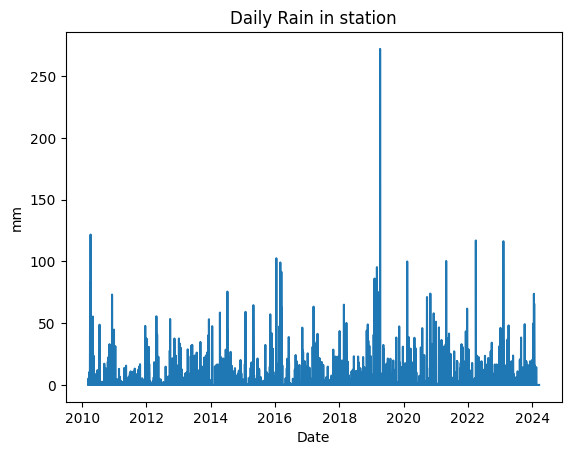

In [2]:
#Precipitation (pr, mm);
timeseries = access_br_dwgd.recuperar_dados_br_dwgd_com_area()
logger.info(f"Dados carregados com sucesso. Total de {len(timeseries)} registros.")
datas = timeseries.index 
plt.plot(timeseries)
plt.title('Daily Rain in station')
plt.xlabel('Date')
plt.ylabel('mm')
plt.show()


In [3]:
lookback = 60
#X_train, y_train = lstm.create_dataset(train, lookback=lookback)
#X_test, y_test = lstm.create_dataset(test, lookback=lookback)
logger.info(f"Preparando sequências com um lookback de {lookback} dias.")
X, y = lstm.create_sequences_pytorch(timeseries, lookback=lookback)
train_size = int(len(timeseries) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


dates_aligned = datas[lookback:]
train_date, test_date = dates_aligned[:train_size] , dates_aligned[train_size:]
logger.info(f"Sequências criadas. Treino: {len(X_train)} amostras, Teste: {len(X_test)} amostras.")


2025-09-29 22:02:11,784 - Lstm BrDwgd - INFO - Preparando sequências com um lookback de 60 dias.
/home/pbose/tcc/pesquisa/utils/lstm.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target = input_data[i+lookback]
2025-09-29 22:02:12,202 - Lstm BrDwgd - INFO - Sequências criadas. Treino: 3587 amostras, Teste: 1478 amostras.


In [4]:
n_epochs = 10
batch_size = 32
model = LstmModel()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)

In [5]:
logger.info(f"Iniciando treinamento do modelo por {n_epochs} épocas com batch_size de {batch_size}.")

# --- Loop de Treinamento ---
# Este loop agora foca APENAS em treinar o modelo
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    logger.debug(f"Época {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(loader):.6f}")


# --- Bloco de Avaliação Final (executado apenas uma vez) ---
logger.info("Treinamento finalizado.")
model.eval()  # modo avaliação
with torch.no_grad():
    # Previsões no conjunto de teste
    y_pred_test = model(X_test)
    
    # Se for LSTM com saída 2D (batch, 1), transforma para 1D
    y_pred_np = y_pred_test.detach().cpu().numpy().flatten()
    y_test_np = y_test.detach().cpu().numpy().flatten()
    
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
    
    # MSE
    mse = mean_squared_error(y_test_np, y_pred_np)
    
    # MAE
    mae = mean_absolute_error(y_test_np, y_pred_np)
    
print(f"Conjunto de Teste:")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
logger.info(f"Avaliação do Modelo - RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}")


# --- Novo Bloco para Imprimir Previsto vs. Esperado ---
logger.info("\n--- Comparando Valores Previstos vs. Esperados (10 primeiros exemplos do teste) ---")
model.eval()
with torch.no_grad():
    # Pega as previsões finais do conjunto de teste
    y_pred_final = model(X_test)
    valores_previstos = y_pred_final.detach().cpu().numpy()
    valores_esperados = y_test.detach().cpu().numpy()

    # Itera sobre os 10 primeiros exemplos e imprime lado a lado
    for i in range(10):
        previsto = valores_previstos[i][0]
        esperado = valores_esperados[i][0]
        logger.info(f"Exemplo {i+1}: Previsto = {previsto}, Esperado = {esperado}")

2025-09-29 22:02:13,832 - Lstm BrDwgd - INFO - Iniciando treinamento do modelo por 10 épocas com batch_size de 32.
2025-09-29 22:02:31,602 - Lstm BrDwgd - DEBUG - Época 1/10, Loss: 95.065871
2025-09-29 22:02:45,731 - Lstm BrDwgd - DEBUG - Época 2/10, Loss: 91.861198
2025-09-29 22:03:02,855 - Lstm BrDwgd - DEBUG - Época 3/10, Loss: 91.405282
2025-09-29 22:03:16,588 - Lstm BrDwgd - DEBUG - Época 4/10, Loss: 90.339058
2025-09-29 22:03:33,428 - Lstm BrDwgd - DEBUG - Época 5/10, Loss: 89.764455
2025-09-29 22:03:48,617 - Lstm BrDwgd - DEBUG - Época 6/10, Loss: 89.213969
2025-09-29 22:04:05,692 - Lstm BrDwgd - DEBUG - Época 7/10, Loss: 89.067474
2025-09-29 22:04:19,609 - Lstm BrDwgd - DEBUG - Época 8/10, Loss: 88.995364
2025-09-29 22:04:33,129 - Lstm BrDwgd - DEBUG - Época 9/10, Loss: 88.624384
2025-09-29 22:04:49,838 - Lstm BrDwgd - DEBUG - Época 10/10, Loss: 88.450242
2025-09-29 22:04:49,839 - Lstm BrDwgd - INFO - Treinamento finalizado.
2025-09-29 22:04:51,421 - Lstm BrDwgd - INFO - Avalia

Conjunto de Teste:
RMSE: 9.2645
MSE: 85.8317
MAE: 4.2598


2025-09-29 22:04:52,801 - Lstm BrDwgd - INFO - Exemplo 1: Previsto = 6.9657301902771, Esperado = 2.200000047683716
2025-09-29 22:04:52,802 - Lstm BrDwgd - INFO - Exemplo 2: Previsto = 1.9194246530532837, Esperado = 0.20000000298023224
2025-09-29 22:04:52,802 - Lstm BrDwgd - INFO - Exemplo 3: Previsto = 1.7172187566757202, Esperado = 0.0
2025-09-29 22:04:52,803 - Lstm BrDwgd - INFO - Exemplo 4: Previsto = 1.4736191034317017, Esperado = 0.0
2025-09-29 22:04:52,803 - Lstm BrDwgd - INFO - Exemplo 5: Previsto = 1.5991920232772827, Esperado = 0.0
2025-09-29 22:04:52,804 - Lstm BrDwgd - INFO - Exemplo 6: Previsto = 1.6478354930877686, Esperado = 0.0
2025-09-29 22:04:52,805 - Lstm BrDwgd - INFO - Exemplo 7: Previsto = 1.6162359714508057, Esperado = 0.0
2025-09-29 22:04:52,805 - Lstm BrDwgd - INFO - Exemplo 8: Previsto = 1.6067661046981812, Esperado = 0.0
2025-09-29 22:04:52,806 - Lstm BrDwgd - INFO - Exemplo 9: Previsto = 1.599892258644104, Esperado = 0.0
2025-09-29 22:04:52,807 - Lstm BrDwgd 

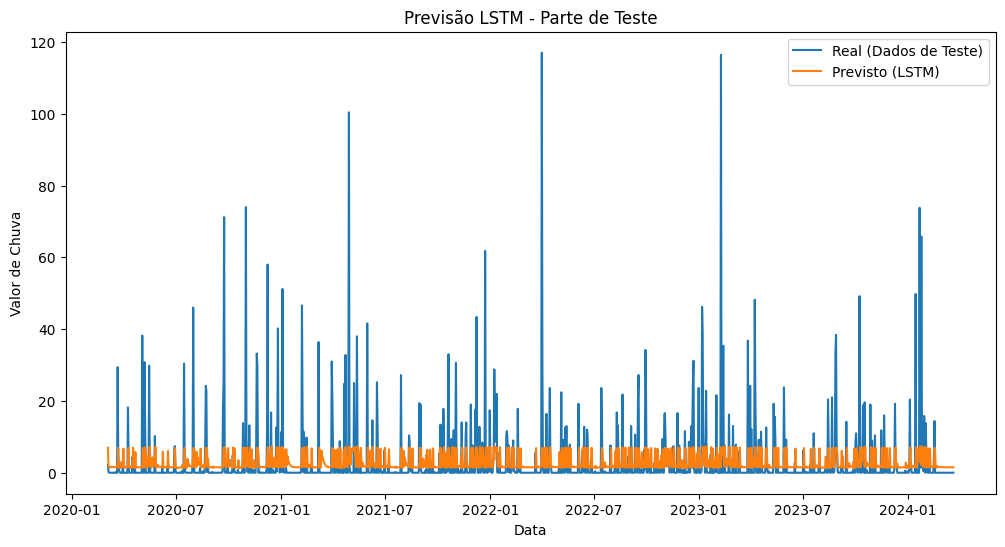

2025-09-29 22:04:52,945 - Lstm BrDwgd - INFO - Execução do script LSTM com BrDwgd finalizada.


In [6]:
plt.figure(figsize=(12, 6))
plt.plot(test_date, y_test_np, label="Real (Dados de Teste)")
plt.plot(test_date, y_pred_np, label="Previsto (LSTM)")
plt.title("Previsão LSTM - Parte de Teste")
plt.xlabel("Data")
plt.ylabel("Valor de Chuva")
plt.legend()
plt.show()
logger.info("Execução do script LSTM com BrDwgd finalizada.")